# <a id='toc1_'></a>[Trading Strategy](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Trading Strategy](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [Net-zero portfolio](#toc4_)    
- [MADL portfolio](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pathlib import Path

import sys
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))
from libs.functions import *

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
preds = pd.read_csv('data/predictions_amadl.csv')
preds.rename(columns={'Unnamed: 0': 'index_original'}, inplace=True)
# preds.columns = preds.columns.str.lower()
preds['timestamp'] = pd.to_datetime(preds['timestamp']) + pd.offsets.MonthEnd(1) # add one month as the target is the prediction for the next month
# preds['y_true'] = preds['y_true'] + ((1+preds['discount'])**(1/12)-1) # add back the short rate to get the true return

data_raw = pd.read_csv('data/data.csv')
discount = data_raw[['timestamp', 'discount']].copy()
discount['timestamp'] = pd.to_datetime(discount['timestamp'])
discount['discount_m'] = (1 + discount['discount'])**(1/12) - 1

omxc25_tickers = pd.read_csv('data/omxc25_constit.csv')
omxc25_tickers = omxc25_tickers[['timestamp', 'ticker']]
omxc25_tickers['in_c25'] = True
omxc25_tickers['timestamp'] = pd.to_datetime(omxc25_tickers['timestamp'])

omxc25_price = pd.read_csv('data/omxc25_price.csv')
omxc25_price['timestamp'] = pd.to_datetime(omxc25_price['timestamp'])
omxc25_price = omxc25_price[(omxc25_price['timestamp'] >= '2021-01-01') & (omxc25_price['timestamp'] <= '2024-12-31')]

omxcb_tickers = pd.read_csv('data/omxcb_constit.csv')
omxcb_tickers = omxcb_tickers[['timestamp', 'ticker']]
omxcb_tickers['timestamp'] = pd.to_datetime(omxcb_tickers['timestamp'])
omxcb_tickers['in_cb'] = True 

omxcb_price = pd.read_csv('data/omxcb_price.csv')
omxcb_price['timestamp'] = pd.to_datetime(omxcb_price['timestamp'])
omxcb_price = omxcb_price[(omxcb_price['timestamp'] >= '2021-01-01') & (omxcb_price['timestamp'] <= '2024-12-31')]

In [3]:
df = (preds
      .merge(omxc25_tickers, on=['ticker','timestamp'], how='left')
      .merge(omxcb_tickers, on=['ticker','timestamp'], how='left')
)
df['in_c25'] = np.where(df['in_c25'].isna(), False, df['in_c25'])
df['in_cb'] = np.where(df['in_cb'].isna(), False, df['in_cb'])

df = df[df['in_cb'] == True]
df = df[df['in_c25'] == True]

# <a id='toc4_'></a>[Net-zero portfolio](#toc0_)

In [4]:
# calculate portfolio returns
df.sort_values(by=['timestamp'])
port_10_1 = pd.DataFrame()
models = ['OLS','LASSO','MLP','MLP-Pyr', 'MLP-AMADL', 'MLP-AMADL-Pyr']
n_tiles = 5

for model in models:
    for dir in ['long', 'short']:
        tmp = df.copy(deep=True)
        tmp = tmp[['timestamp', model, 'y_true']]
        tmp['decile'] = df.groupby(['timestamp'])[model].transform(lambda x: pd.qcut(x, n_tiles, labels=False))
        # create action column based on decile
        if dir == 'long':
            tmp['action'] = np.where(tmp['decile'] == n_tiles-1, 1, 0)
        else:
            tmp['action'] = np.where(tmp['decile'] == 0, -1, 0)
        # find stocks in position
        tmp[f'n_dir'] = (tmp['action'] == (1 if dir == 'long' else -1)).astype(int)
        tmp[f'n_dir'] = tmp.groupby('timestamp')[f'n_dir'].transform('sum')
        
        # calculate return for the direction (equal weighted)  
        tmp[f'{model}_{dir}'] = tmp['action']*tmp['y_true']/tmp[f'n_dir'] # multiply by action to get the return for the direction

        # sum the returns for each month
        tmp = tmp.groupby('timestamp')[f'{model}_{dir}'].sum().reset_index()
        # calculate cumulative return and percentage return
        tmp[f'{model}_{dir}'] = tmp[f'{model}_{dir}'] + 1
        tmp[f'{model}_{dir}_cum'] = tmp[f'{model}_{dir}'].cumprod() * 100
        tmp[f'{model}_{dir}'] = tmp[f'{model}_{dir}'] - 1

        port_10_1 = pd.concat([port_10_1, tmp], axis=1)
port_10_1 = port_10_1.loc[:, ~port_10_1.columns.duplicated()]

# start with an initial value of 100
port_10_1.loc[-1] = [pd.Timestamp('2021-01-01'), 
                     np.nan, 100, np.nan, 100, # OLS 
                     np.nan, 100, np.nan, 100, # LASSO
                     np.nan, 100, np.nan, 100, # MLP
                     np.nan, 100, np.nan, 100, # MLP-Pyr
                     np.nan, 100, np.nan, 100, # MLP-AMADL
                     np.nan, 100, np.nan, 100, # MLP-AMADL-Pyr
                     ]
port_10_1 = port_10_1.sort_index().reset_index(drop=True)


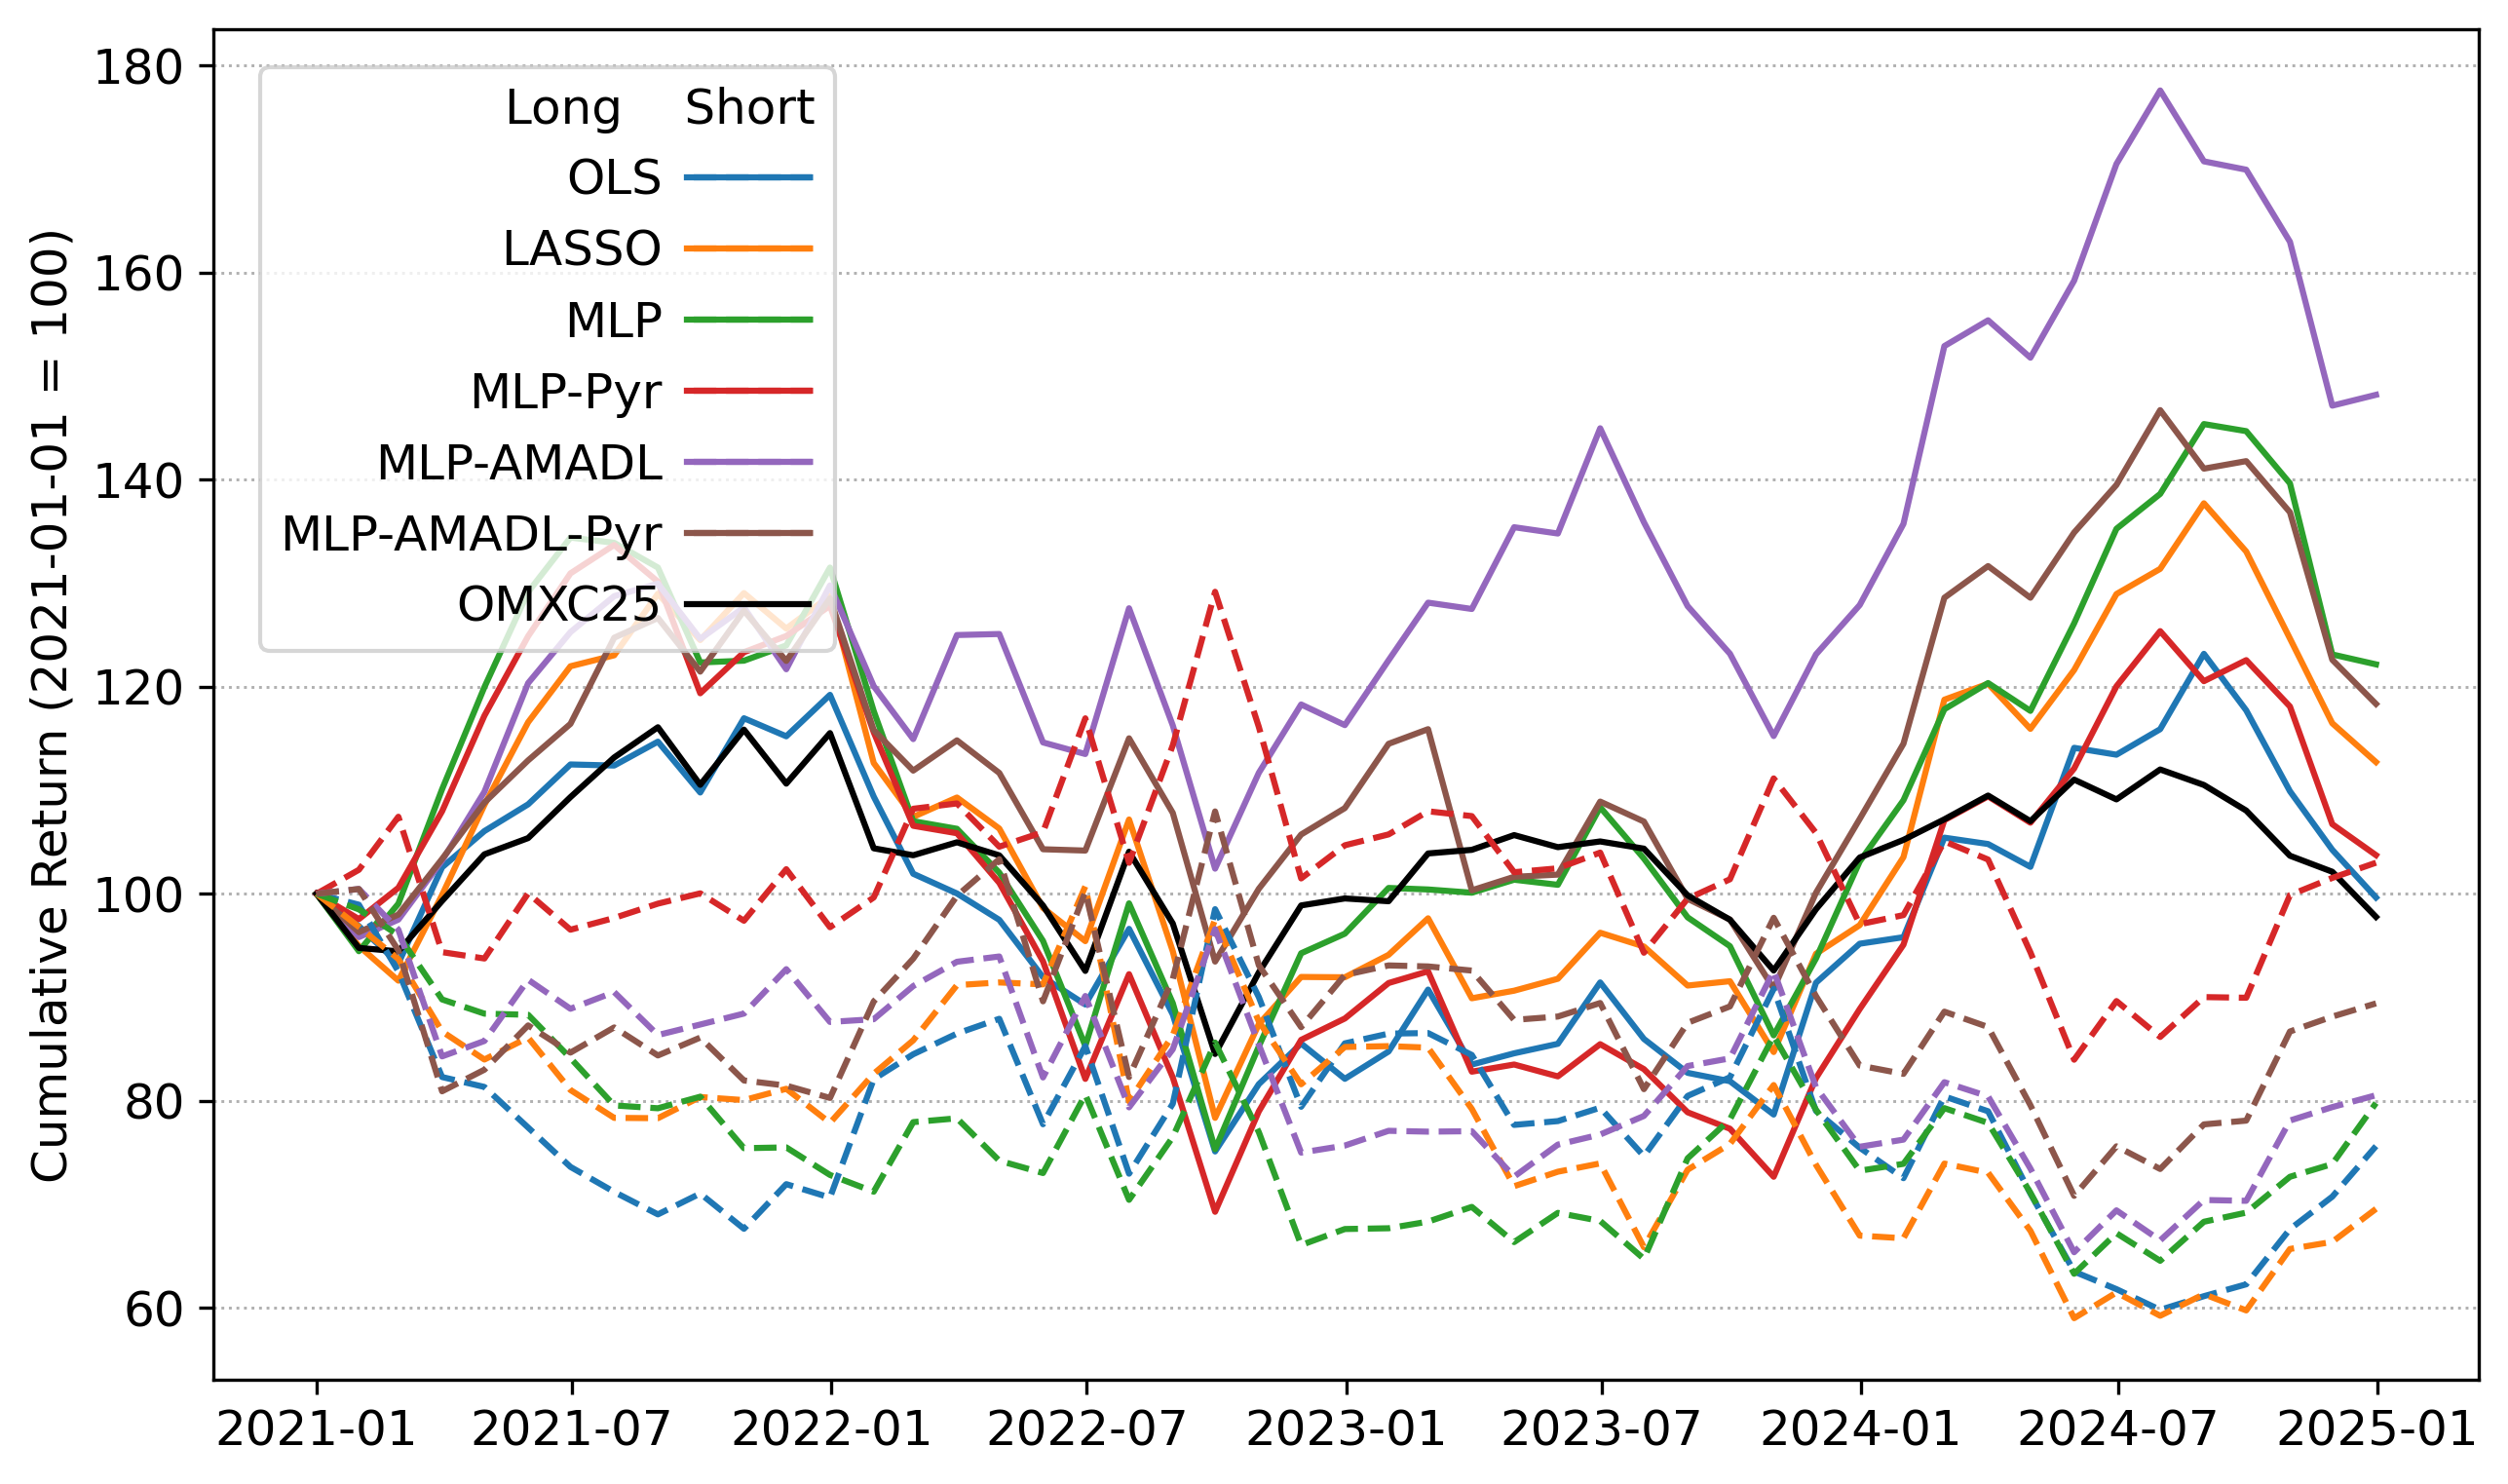

In [5]:
# plotting
fig, ax = plt.subplots(figsize=(10, 6))
default_cycler = plt.rcParams['axes.prop_cycle']
for model in models:    
    ax.plot(port_10_1['timestamp'], port_10_1[f'{model}_long_cum'], label=f'{model}', linestyle='-')
ax.plot(omxc25_price['timestamp'], omxc25_price['cumulative'], label='OMXC25', linestyle='-', color='black')
ax = plt.gca()
ax.set_prop_cycle(default_cycler)
for model in models:    
    ax.plot(port_10_1['timestamp'], port_10_1[f'{model}_short_cum'], label=f' ', linestyle='--')
ax.set_ylabel('Cumulative Return (2021-01-01 = 100)')
ax.yaxis.grid(True, which='major', linestyle=':', linewidth=0.7)

leg = ax.legend(ncol=2, loc='upper left',frameon=True, markerfirst=False, handlelength=2.5,handletextpad=0.5, bbox_to_anchor=(0.01, 0.99, 0.275 ,0.0), mode='expand', title='Long    Short')
leg._legend_box.align = "right"

plt.savefig('figs/port10-1_return_amadl.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Tables

### Decile performance

In [6]:
asset_ret = (
    df
    .pivot_table(
        index='timestamp',
        columns='ticker',
        values='y_true',
        aggfunc='mean'
    )
    .fillna(0)
)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
for m in models:
    # df[f'dec_{m}'] = assign_decile(df, m, n_tiles)
    df[f'dec_{m}'] = df.groupby(['timestamp'])[m].transform(lambda x: pd.qcut(x, n_tiles, labels=False)+1)

tbl_panel = {}
for m in models:
    dec_r = (
        df
        .groupby(['timestamp', f'dec_{m}'])['y_true']
        .mean()
        .unstack(f'dec_{m}')
        .sort_index()
    )
    dec_p = (
        df
        .groupby(['timestamp', f'dec_{m}'])[m]
        .mean()
        .unstack(f'dec_{m}')
        .sort_index()
    )

    records = []
    for d in range(1, n_tiles+1):
        r_ts = dec_r[d]
        p_ts = dec_p[d]
        avg = r_ts.mean()
        sd  = r_ts.std(ddof=1)
        sr  = avg/sd * np.sqrt(12)
        p   = p_ts.mean() * 100
        avg = avg * 100
        records.append({'decile':d, 'Pred, %':p, 'Avg, %':avg, 'SD':sd, 'SR':sr})

    # now H–L synthetic series
    r_hl = dec_r[n_tiles] - dec_r[1]
    p_hl = dec_p[n_tiles] - dec_p[1]
    avg = r_hl.mean()
    sd  = r_hl.std(ddof=1)
    sr  = avg/sd * np.sqrt(12)
    p   = p_hl.mean() * 100
    avg = avg * 100
    records.append({'decile':'H-L','Pred, %':p,'Avg, %':avg,'SD':sd,'SR':sr})

    df_panel = pd.DataFrame(records).set_index('decile')
    tbl_panel[m] = df_panel
    tbl_panel[m].rename(index={1: 'Low (L)'}, inplace=True)
    tbl_panel[m].rename(index={n_tiles: 'High (H)'}, inplace=True)


In [7]:
model_groups = [['OLS','LASSO'], ['MLP','MLP-Pyr'], ['MLP-AMADL','MLP-AMADL-Pyr']]
col_names = ['Pred, %','Avg, %','SD','SR']
tab = portfolio_panel(tbl_panel, model_groups, col_names)

tab = tab.replace('%', '\\%')

with open('tabs/portfolio_table_amadl.tex', 'w') as f:
    f.write(tab)
print(tab)

\begin{tabular}{lrrrrrrrr}
\hline \hline \\ [-1.8ex]
 & \multicolumn{4}{c}{OLS} & \multicolumn{4}{c}{LASSO} \\
 \cmidrule(lr){2-5} \cmidrule(lr){6-9}
  & Pred, \% & Avg, \% & SD & SR & Pred, \% & Avg, \% & SD & SR \\
\midrule
Low (L) & -3.460 & 0.281 & 0.079 & 0.123 & -1.602 & 0.505 & 0.070 & 0.249 \\
2 & -1.335 & -0.219 & 0.063 & -0.120 & -0.356 & -0.075 & 0.065 & -0.040 \\
3 & -0.018 & 0.568 & 0.054 & 0.364 & 0.376 & -0.399 & 0.052 & -0.267 \\
4 & 1.348 & 0.723 & 0.064 & 0.394 & 1.134 & 1.069 & 0.060 & 0.619 \\
High (H) & 3.636 & 0.177 & 0.062 & 0.099 & 2.485 & 0.471 & 0.067 & 0.244 \\
H-L & 7.096 & -0.104 & 0.065 & -0.055 & 4.088 & -0.034 & 0.071 & -0.017 \\
\midrule
 & \multicolumn{4}{c}{MLP} & \multicolumn{4}{c}{MLP-Pyr} \\
 \cmidrule(lr){2-5} \cmidrule(lr){6-9}
  & Pred, \% & Avg, \% & SD & SR & Pred, \% & Avg, \% & SD & SR \\
\midrule
Low (L) & -0.085 & 0.254 & 0.066 & 0.133 & -0.252 & -0.273 & 0.065 & -0.145 \\
2 & 0.390 & 0.195 & 0.054 & 0.126 & 0.385 & 0.913 & 0.056 & 0.566 \

### Drawdown, turnover, and max 1-month loss

In [8]:
tbl_perf = {}
for m in models:
    # 1) get equal‐weighted return series for each decile
    dec_r = (
      df
      .groupby(['timestamp', f'dec_{m}'])['y_true']
      .mean()
      .unstack(f'dec_{m}')
      .sort_index()
    )
    # extract Low, High, H-L
    r_low  = dec_r[1]
    r_high = dec_r[n_tiles]
    r_hl   = r_high - r_low

    # 2) build weight matrices for each
    #    using only y_true presence to define membership
    w_low  = equal_weight_matrix(df[df[f'dec_{m}']==1], f'dec_{m}')
    w_high = equal_weight_matrix(df[df[f'dec_{m}']==n_tiles], f'dec_{m}')
    # H-L weights = long high, short low
    w_hl   = w_high - w_low

    stats = {
      'Low':  stats_for_series(r_low,  w_low, asset_ret),
      'High': stats_for_series(r_high, w_high, asset_ret),
      'H-L':  stats_for_series(r_hl,   w_hl, asset_ret),
    }

    tbl_perf[m] = pd.DataFrame(stats).T

In [9]:
col_names = ['Max DD, %', 'Max 1M loss, %', 'Turnover, %']
model_groups = [['OLS'], ['LASSO'], ['MLP'], ['MLP-Pyr']]
tab_perf = portfolio_panel(tbl_perf, model_groups, col_names)
tab_perf = tab_perf.replace('%', '\\%')  # escape percent sign for LaTeX

with open('tabs/portfolio_table_dd_mloss_turn_amadl.tex', 'w') as f:
    f.write(tab_perf)
print(tab_perf)

\begin{tabular}{lrrr}
\hline \hline \\ [-1.8ex]
 & \multicolumn{3}{c}{OLS} \\
 \cmidrule(lr){2-4}
  & Max DD, \% & Max 1M loss, \% & Turnover, \% \\
\midrule
Low & 40.467 & 23.583 & 38.230 \\
High & 37.000 & 14.979 & 33.062 \\
H-L & 26.582 & 17.271 & 64.149 \\
\midrule
 & \multicolumn{3}{c}{LASSO} \\
 \cmidrule(lr){2-4}
  & Max DD, \% & Max 1M loss, \% & Turnover, \% \\
\midrule
Low & 26.786 & 12.972 & 32.229 \\
High & 39.285 & 17.042 & 32.031 \\
H-L & 34.338 & 14.868 & 56.937 \\
\midrule
 & \multicolumn{3}{c}{MLP} \\
 \cmidrule(lr){2-4}
  & Max DD, \% & Max 1M loss, \% & Turnover, \% \\
\midrule
Low & 27.904 & 15.006 & 35.547 \\
High & 43.960 & 15.783 & 36.505 \\
H-L & 39.949 & 12.760 & 57.935 \\
\midrule
 & \multicolumn{3}{c}{MLP-Pyr} \\
 \cmidrule(lr){2-4}
  & Max DD, \% & Max 1M loss, \% & Turnover, \% \\
\midrule
Low & 32.795 & 12.972 & 33.451 \\
High & 48.183 & 15.783 & 37.919 \\
H-L & 34.160 & 12.129 & 64.934 \\
\hline \hline
\end{tabular}


### Index table

In [10]:
# create naive portfolio
naive_port = df.copy(deep=True)
naive_port = naive_port[['timestamp', 'ticker', 'y_true']]
naive_port.rename(columns={'y_true': 'return'}, inplace=True)
naive_port = naive_port.groupby('timestamp')['return'].mean().reset_index()
# insert row for 2021-01-01 with return NaN
naive_port.loc[-1] = [pd.Timestamp('2021-01-01'), pd.NA]
naive_port = naive_port.sort_index().reset_index(drop=True)

/var/folders/yw/jsw5n53s1cb1s2q6tt0msrm00000gn/T/ipykernel_55474/749506275.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  naive_port.loc[-1] = [pd.Timestamp('2021-01-01'), pd.NA]


In [11]:
# omxc25 performance
tbl_idx = {}
tbl_idx['OMXC25'] = pd.DataFrame({
    'Avg, %': [omxc25_price['return'].mean()*100],
    'Std': [omxc25_price['return'].std(ddof=1)],
    'SR': [omxc25_price['return'].mean()/omxc25_price['return'].std(ddof=1) * np.sqrt(12)],
    'Max DD, %': [max_drawdown(omxc25_price['return'])*100],
    'Max 1M loss, %':  [-100 *np.min(omxc25_price['return'])],
}, index=['Long'])
# add naive portfolio
# tbl_idx['Naive'] = pd.DataFrame({
#     'Avg, %': [naive_port['return'].mean()*100],
#     'Std': [naive_port['return'].std(ddof=1)],
#     'SR': [naive_port['return'].mean()/naive_port['return'].std(ddof=1) * np.sqrt(12)],
#     'Max DD, %': [max_drawdown(naive_port['return'])*100],
#     'Max 1M loss, %':  [-100 *np.min(naive_port['return'])],
# }, index=['Long'])

model_groups = [['OMXC25']]
col_names = ['Avg, %', 'Std', 'SR', 'Max DD, %', 'Max 1M loss, %']
tab_idx = portfolio_panel(tbl_idx, model_groups, col_names)

tab_idx = tab_idx.replace('%', '\\%')  # escape percent sign for LaTeX

with open('tabs/omxc25_table.tex', 'w') as f:
    f.write(tab_idx)
# print(tab_idx)

# <a id='toc5_'></a>[MADL portfolio](#toc0_)

In [12]:
port_directional = pd.DataFrame()

for model in models:
    tmp = df.copy(deep=True)
    tmp['action'] = np.where(np.sign(tmp[model]) == 1, 1, np.where(np.sign(tmp[model]) == -1, -1, 0))
    tmp['action'] = np.where(np.sign(tmp[model]) == 1, 1, -1)

    tmp['n_short'] = (tmp['action'] == -1).astype(int)
    tmp['n_long'] = (tmp['action'] == 1).astype(int)
    n_short = tmp.groupby('timestamp')['n_short'].transform('sum')
    n_long = tmp.groupby('timestamp')['n_long'].transform('sum')
    tmp['weight'] = np.where(tmp['action'] == 1, 1/n_long, np.where(tmp['action'] == -1, 1/n_short, 0))

    tmp[f'{model}_return'] = tmp['action'] * tmp['y_true'] * tmp['weight']
    
    # pure one directional strategy
    # tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true'] * tmp['weight'],0)
    # tmp[f'{model}_return'] = np.where(tmp['action'] == -1, - tmp['y_true'] * tmp['weight'],0)

    tmp = tmp.groupby('timestamp')[f'{model}_return'].sum().reset_index()
    tmp[f'{model}_return'] = tmp[f'{model}_return'] + 1
    tmp[f'{model}_return_cum'] = tmp[f'{model}_return'].cumprod() * 100
    tmp[f'{model}_return'] = tmp[f'{model}_return'] - 1
    
    port_directional = pd.concat([port_directional, tmp], axis=1)
port_directional = port_directional.loc[:, ~port_directional.columns.duplicated()]
port_directional.loc[-1] = [pd.Timestamp('2021-01-01'), 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100]
port_directional = port_directional.sort_index().reset_index(drop=True)

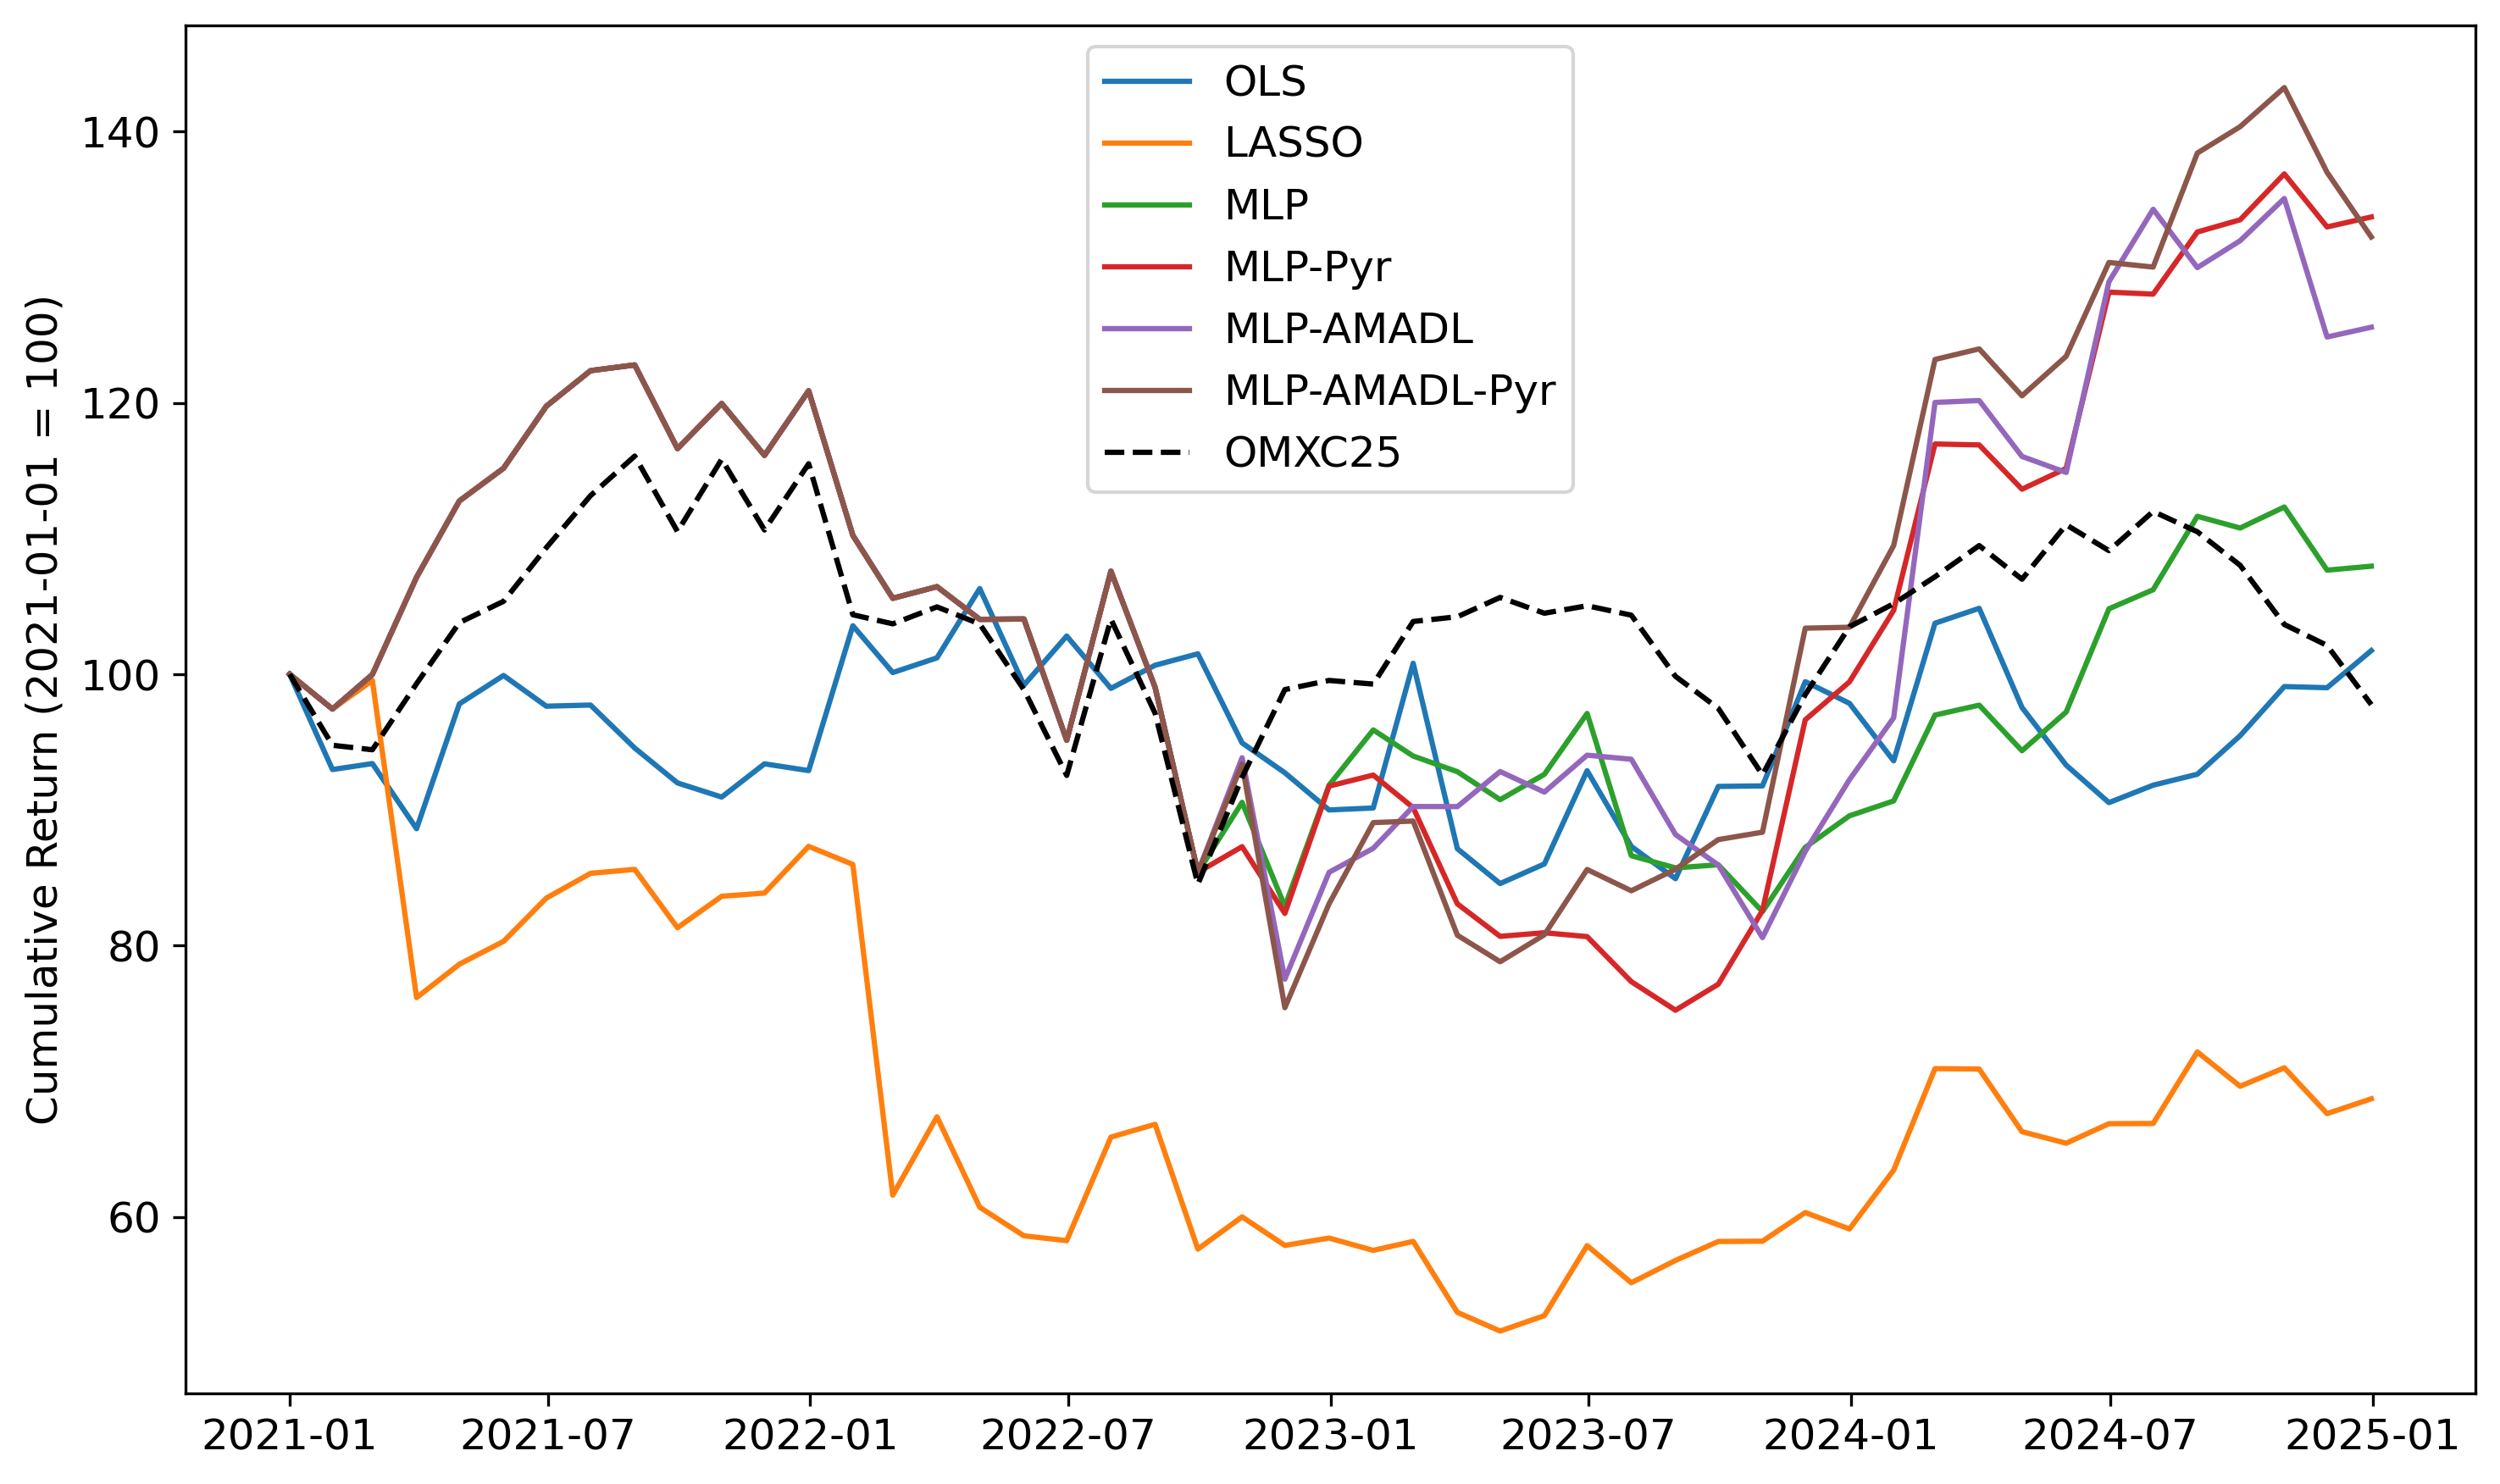

In [13]:
# plotting
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(port_directional['timestamp'], port_directional[f'{model}_return_cum'], label=model)
plt.plot(omxc25_price['timestamp'], omxc25_price['cumulative'], label='OMXC25', linestyle='--', color='black')
# plt.plot(omxcb_price['timestamp'], omxcb_price['cumulative'], label='OMXCB', linestyle='--')
# plt.title('Cumulative Returns by Model')
# plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return (2021-01-01 = 100)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()